# Pothole Detection - YOLO Only (Complete Pipeline)

**Notebook Lengkap: Training + Evaluation YOLO Murni**

Pipeline:
1. ✅ Setup & Install Dependencies
2. ✅ Prepare Dataset (YOLO format)
3. ✅ Configure YOLO Training
4. ✅ Train YOLO Model from Scratch
5. ✅ Evaluate Model Performance
6. ✅ Visualize Results
7. ✅ Compare with Hybrid Approach

**Tujuan**: Mengevaluasi performa YOLO murni tanpa preprocessing PCD untuk dibandingkan dengan hybrid approach.

## 1. Setup & Installation

In [21]:
# # Install ultralytics (YOLOv8)
# print("📦 Installing Ultralytics YOLO...\n")
# !pip install -q ultralytics opencv-python numpy matplotlib

# print("✅ Installation complete!")

In [22]:
# Import libraries
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import yaml
import json
from pathlib import Path
from tqdm import tqdm
import shutil
from datetime import datetime

# Set matplotlib style
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("="*70)
print("✅ All libraries imported successfully!")
print("="*70)
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print("="*70)

✅ All libraries imported successfully!
OpenCV version: 4.12.0
NumPy version: 2.2.6


## 2. Configuration

In [23]:
DATASET_PATH = "dataset/dataset"  # ← GANTI INI dengan path dataset Anda!

# Output directories
OUTPUT_DIR = "yolo_only_complete"
TRAIN_OUTPUT = os.path.join(OUTPUT_DIR, "training")
EVAL_OUTPUT = os.path.join(OUTPUT_DIR, "evaluation")

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(TRAIN_OUTPUT, exist_ok=True)
os.makedirs(EVAL_OUTPUT, exist_ok=True)

# Training configuration
TRAINING_CONFIG = {
    'model': 'yolov8n.pt',           # Pre-trained model (nano - fastest)
    # 'model': 'yolov8s.pt',         # Small (uncomment untuk model lebih besar)
    # 'model': 'yolov8m.pt',         # Medium (uncomment untuk model lebih besar)
    'epochs': 50,                     # Number of training epochs
    'batch_size': 16,                 # Batch size (sesuaikan dengan GPU/RAM)
    'imgsz': 640,                     # Image size
    'patience': 10,                   # Early stopping patience
    'device': 0,                      # 0 untuk GPU, 'cpu' untuk CPU
}

# Evaluation configuration
EVAL_CONFIG = {
    'conf_threshold': 0.25,           # Confidence threshold
    'iou_threshold': 0.5,             # IoU threshold untuk NMS
}

print("="*70)
print("CONFIGURATION LOADED")
print("="*70)
print(f"Dataset Path:      {DATASET_PATH}")
print(f"Output Directory:  {OUTPUT_DIR}")
print(f"\nTraining Config:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key:<15}: {value}")
print(f"\nEvaluation Config:")
for key, value in EVAL_CONFIG.items():
    print(f"  {key:<15}: {value}")
print("="*70)

CONFIGURATION LOADED
Dataset Path:      dataset/dataset
Output Directory:  yolo_only_complete

Training Config:
  model          : yolov8n.pt
  epochs         : 50
  batch_size     : 16
  imgsz          : 640
  patience       : 10
  device         : 0

Evaluation Config:
  conf_threshold : 0.25
  iou_threshold  : 0.5


## 3. Verify Dataset Structure

In [24]:
def verify_dataset_structure(dataset_path): 
    """
    Verify that dataset has correct YOLO structure
    """
    print("\n" + "="*70)
    print("VERIFYING DATASET STRUCTURE")
    print("="*70)
    
    required_splits = ['train', 'valid']
    optional_splits = ['test']
    
    dataset_ok = True
    stats = {}
    
    for split in required_splits + optional_splits:
        img_dir = os.path.join(dataset_path, split, 'images')
        label_dir = os.path.join(dataset_path, split, 'labels')
        
        if not os.path.exists(img_dir):
            if split in required_splits:
                print(f"❌ Missing required directory: {img_dir}")
                dataset_ok = False
            else:
                print(f"⚠️  Optional directory not found: {img_dir}")
            continue
        
        if not os.path.exists(label_dir):
            if split in required_splits:
                print(f"❌ Missing required directory: {label_dir}")
                dataset_ok = False
            else:
                print(f"⚠️  Optional directory not found: {label_dir}")
            continue
        
        # Count images and labels
        images = glob.glob(os.path.join(img_dir, '*.jpg')) + \
                 glob.glob(os.path.join(img_dir, '*.png'))
        labels = glob.glob(os.path.join(label_dir, '*.txt'))
        
        stats[split] = {
            'images': len(images),
            'labels': len(labels)
        }
        
        status = "✅" if len(images) > 0 else "⚠️"
        print(f"{status} {split.upper():6} - Images: {len(images):4}, Labels: {len(labels):4}")
        
        if len(images) == 0 and split in required_splits:
            dataset_ok = False
    
    print("="*70)
    
    if dataset_ok:
        print("✅ Dataset structure is valid!")
    else:
        print("❌ Dataset structure has issues. Please fix before training.")
    
    print("="*70)
    return dataset_ok, stats

# Verify dataset
dataset_ok, dataset_stats = verify_dataset_structure(DATASET_PATH)


VERIFYING DATASET STRUCTURE
✅ TRAIN  - Images:  465, Labels:  465
✅ VALID  - Images:  133, Labels:  133
✅ TEST   - Images:   67, Labels:   67
✅ Dataset structure is valid!


## 4. Create YOLO Dataset Configuration File

In [25]:
# Create data.yaml file for YOLO training
def create_yaml_config(dataset_path, output_path):
    """
    Create YOLO dataset configuration YAML file
    """
    # Get absolute paths
    abs_dataset_path = os.path.abspath(dataset_path)
    
    config = {
        'path': abs_dataset_path,
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',  # Optional
        'nc': 1,  # Number of classes (pothole = 1 class)
        'names': ['pothole']  # Class names
    }
    
    yaml_path = os.path.join(output_path, 'data.yaml')
    
    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False, sort_keys=False)
    
    print("\n" + "="*70)
    print("YOLO CONFIGURATION FILE CREATED")
    print("="*70)
    print(f"Location: {yaml_path}\n")
    print("Configuration:")
    print(yaml.dump(config, default_flow_style=False, sort_keys=False))
    print("="*70)
    
    return yaml_path

# Create YAML config
yaml_config_path = create_yaml_config(DATASET_PATH, OUTPUT_DIR)


YOLO CONFIGURATION FILE CREATED
Location: yolo_only_complete\data.yaml

Configuration:
path: d:\Semester 7\Tubes_PCD\dataset\dataset
train: train/images
val: valid/images
test: test/images
nc: 1
names:
- pothole



## 5. Initialize YOLO Model

In [26]:
# Load pre-trained YOLO model
print("\n" + "="*70)
print("INITIALIZING YOLO MODEL")
print("="*70)

model = YOLO(TRAINING_CONFIG['model'])

print(f"✅ Model loaded: {TRAINING_CONFIG['model']}")
print(f"   Model architecture: {model.model.__class__.__name__}")
print("="*70)


INITIALIZING YOLO MODEL
✅ Model loaded: yolov8n.pt
   Model architecture: DetectionModel


## 6. Train YOLO Model

**⚠️ PENTING:** Training bisa memakan waktu lama tergantung:
- Ukuran dataset
- Jumlah epochs
- Hardware (GPU vs CPU)

**Perkiraan waktu:**
- GPU: 10-30 menit untuk 50 epochs
- CPU: 1-3 jam untuk 50 epochs

In [34]:
# Train the model
print("\n" + "="*70)
print("STARTING YOLO TRAINING")
print("="*70)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n🚀 Training in progress... This may take a while...\n")

try:
    results = model.train(
        data=yaml_config_path,
        epochs=TRAINING_CONFIG['epochs'],
        batch=TRAINING_CONFIG['batch_size'],
        imgsz=TRAINING_CONFIG['imgsz'],
        patience=TRAINING_CONFIG['patience'],
        device=TRAINING_CONFIG['device'],
        project=TRAIN_OUTPUT,
        name='yolo_pothole',
        exist_ok=True,
        verbose=True,
        save=True,
        plots=True
    )
    
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETED SUCCESSFULLY!")
    print("="*70)
    print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*70)
    
    # Path to best model
    best_model_path = os.path.join(TRAIN_OUTPUT, 'yolo_pothole', 'weights', 'best.pt')
    print(f"\n📁 Best model saved at: {best_model_path}")
    
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    print("\nPossible solutions:")
    print("1. Check if dataset path is correct")
    print("2. Reduce batch_size if you have memory issues")
    print("3. Change device to 'cpu' if GPU issues")
    print("4. Ensure dataset has valid YOLO format labels")


STARTING YOLO TRAINING
Start time: 2025-11-18 08:02:21

🚀 Training in progress... This may take a while...

Ultralytics 8.3.228  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_only_complete\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_p

## 7. Visualize Training Results

In [35]:
import os

print("results_dir:", results_dir)
print("results_img:", results_img)
print("exists?", os.path.exists(results_img))


results_dir: yolo_only_complete\training\yolo_pothole
results_img: yolo_only_complete\training\yolo_pothole\results.png
exists? True


In [36]:
# Display training curves
results_dir = os.path.join(TRAIN_OUTPUT, 'yolo_pothole')
results_img = os.path.join(results_dir, 'results.png')

if os.path.exists(results_img):
    print("\n📊 Training Results:")
    img = cv2.imread(results_img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(16, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('YOLO Training Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Training results plot not found. Training might have failed.")

# List other available plots
print("\n📁 Training artifacts saved in:")
print(f"   {results_dir}")
if os.path.exists(results_dir):
    plots = glob.glob(os.path.join(results_dir, '*.png'))
    print(f"\n   Available plots ({len(plots)}):")
    for plot in plots:
        print(f"   - {os.path.basename(plot)}")


📊 Training Results:


<Figure size 1600x1000 with 1 Axes>


📁 Training artifacts saved in:
   yolo_only_complete\training\yolo_pothole

   Available plots (7):
   - BoxF1_curve.png
   - BoxPR_curve.png
   - BoxP_curve.png
   - BoxR_curve.png
   - confusion_matrix.png
   - confusion_matrix_normalized.png
   - results.png


exists? True


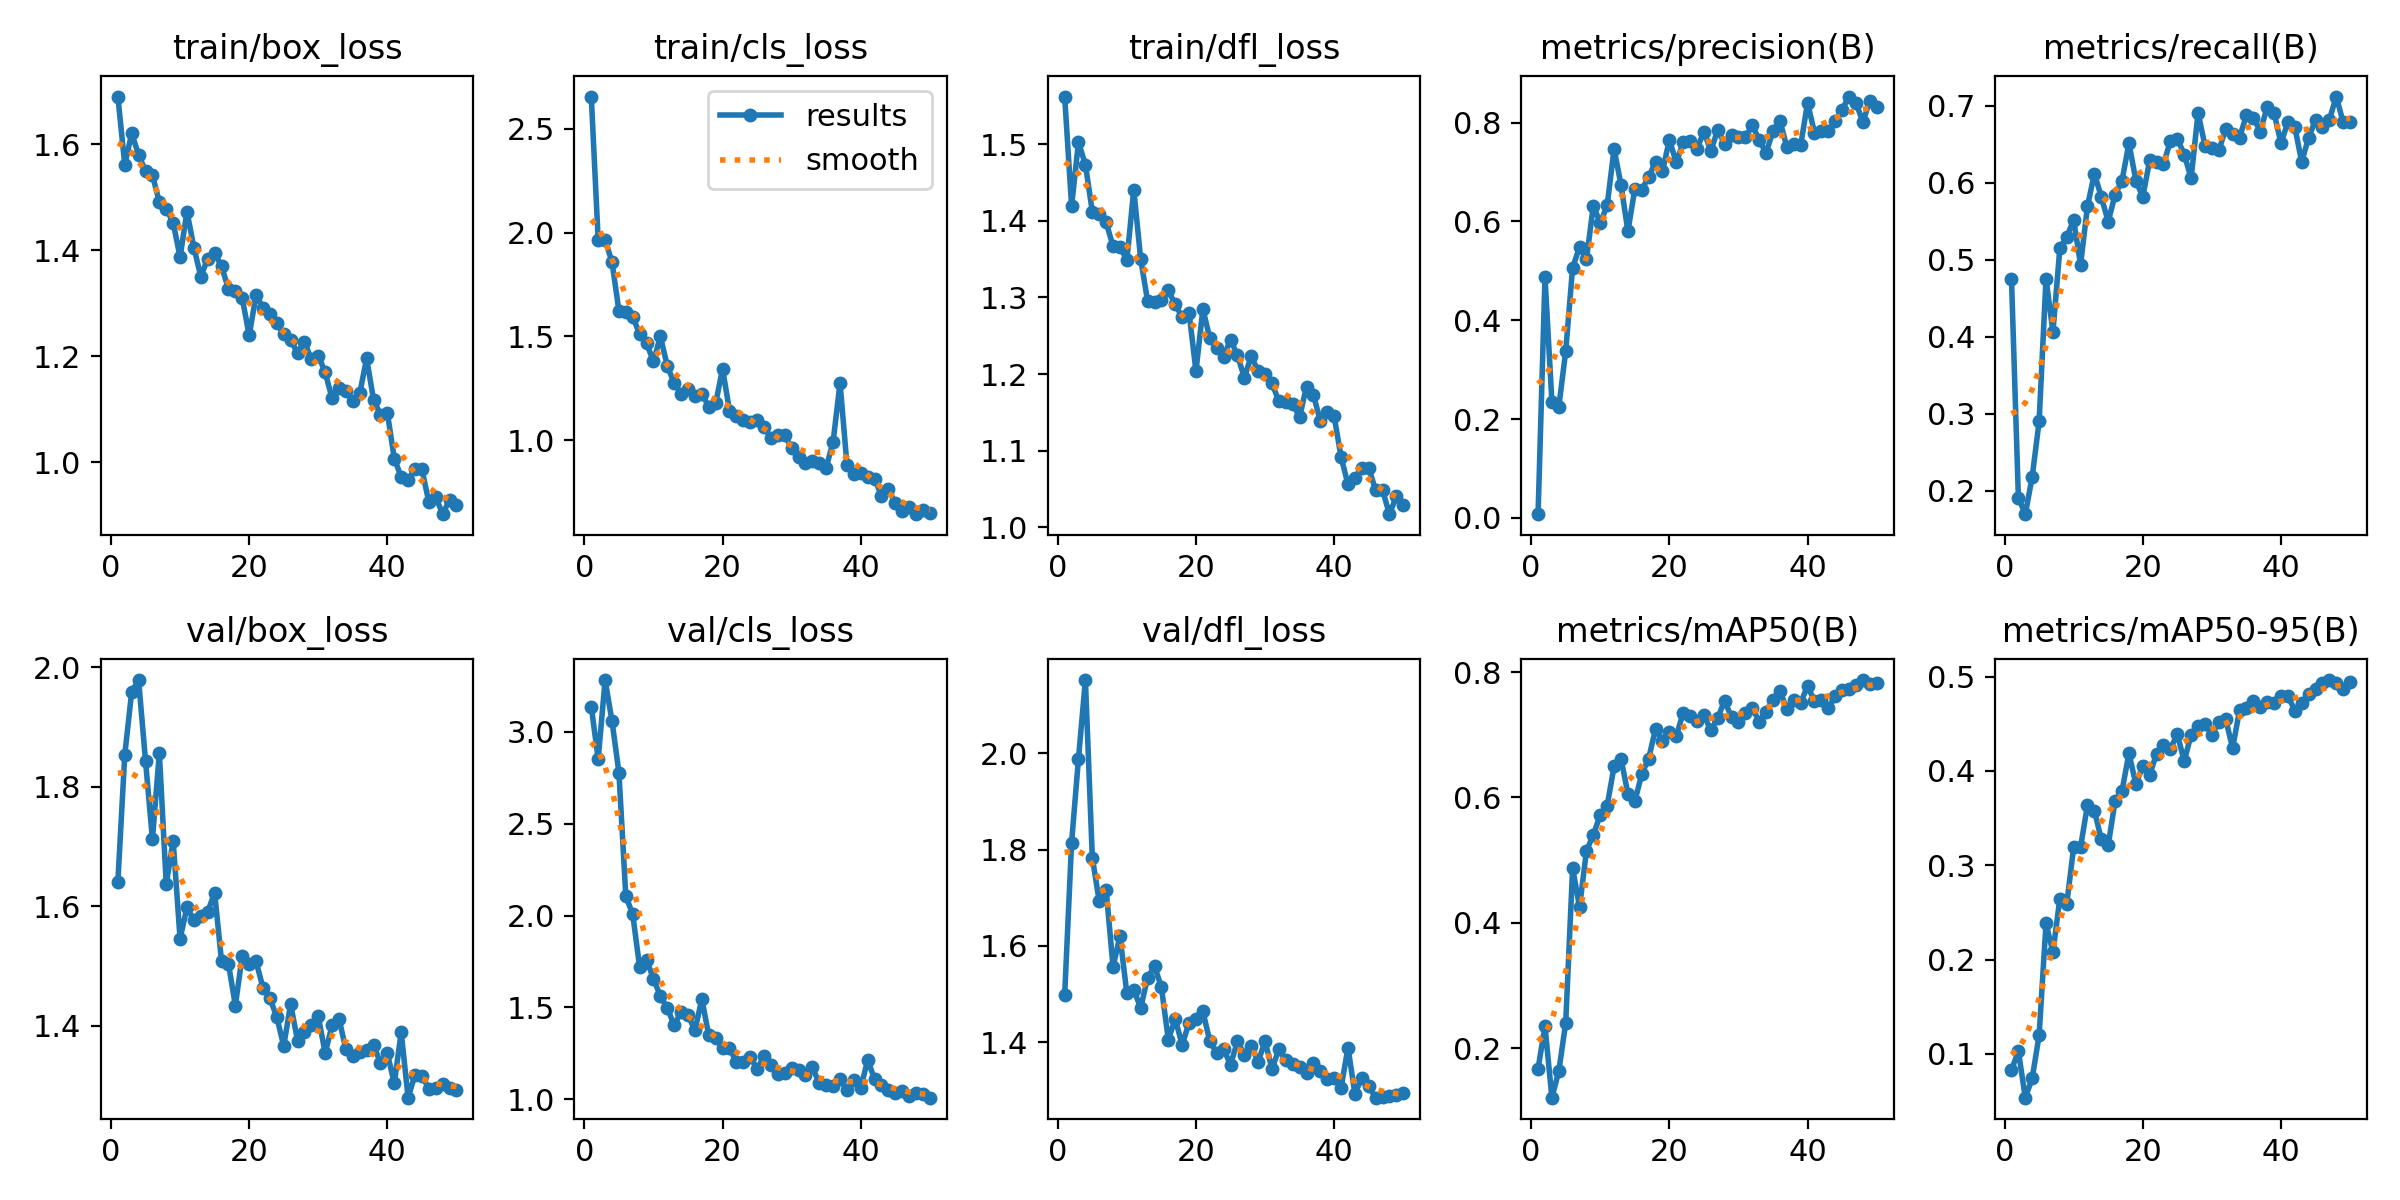

In [37]:
from IPython.display import Image, display
from pathlib import Path

results_dir = Path("yolo_only_complete/training/yolo_pothole")
results_img = results_dir / "results.png"

print("exists?", results_img.exists())
display(Image(filename=str(results_img)))


## 8. Load Best Model for Evaluation

In [38]:
# Load the best trained model
best_model_path = os.path.join(TRAIN_OUTPUT, 'yolo_pothole', 'weights', 'best.pt')

if os.path.exists(best_model_path):
    print("\n" + "="*70)
    print("LOADING BEST MODEL")
    print("="*70)
    
    model_eval = YOLO(best_model_path)
    
    print(f"✅ Best model loaded from: {best_model_path}")
    print("="*70)
else:
    print("❌ Best model not found. Please ensure training completed successfully.")
    print(f"   Expected path: {best_model_path}")


LOADING BEST MODEL
✅ Best model loaded from: yolo_only_complete\training\yolo_pothole\weights\best.pt


## 9. Evaluation Functions

In [39]:
def load_yolo_labels(label_path, img_width, img_height):
    """
    Load YOLO format labels and convert to pixel coordinates
    """
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                _, x_center, y_center, width, height = map(float, parts)
                
                # Convert from normalized YOLO format to pixel coordinates
                x1 = int((x_center - width/2) * img_width)
                y1 = int((y_center - height/2) * img_height)
                x2 = int((x_center + width/2) * img_width)
                y2 = int((y_center + height/2) * img_height)
                
                boxes.append([x1, y1, x2, y2])
    
    return boxes


def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU)
    """
    # Handle different box formats
    if len(box1) == 4:
        if box1[2] < 1000:  # Likely [x, y, w, h]
            x1_1, y1_1, x2_1, y2_1 = box1[0], box1[1], box1[0] + box1[2], box1[1] + box1[3]
        else:  # Already [x1, y1, x2, y2]
            x1_1, y1_1, x2_1, y2_1 = box1
    
    x1_2, y1_2, x2_2, y2_2 = box2
    
    # Calculate intersection
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i < x1_i or y2_i < y1_i:
        return 0.0
    
    intersection = (x2_i - x1_i) * (y2_i - y1_i)
    
    # Calculate union
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0


def calculate_map(all_predictions, all_ground_truths, iou_thresholds=[0.5]):
    """
    Calculate mean Average Precision (mAP)
    """
    aps = []
    
    for iou_thresh in iou_thresholds:
        # Collect all predictions
        all_preds = []
        for img_idx, preds in enumerate(all_predictions):
            for box, conf in preds:
                all_preds.append((conf, box, img_idx))
        
        # Sort by confidence
        all_preds.sort(key=lambda x: x[0], reverse=True)
        
        # Count total ground truths
        total_gt = sum(len(gt) for gt in all_ground_truths)
        
        if total_gt == 0:
            aps.append(0.0)
            continue
        
        # Track matched ground truths
        gt_matched = [set() for _ in range(len(all_ground_truths))]
        
        tp = np.zeros(len(all_preds))
        fp = np.zeros(len(all_preds))
        
        # For each prediction
        for pred_idx, (conf, pred_box, img_idx) in enumerate(all_preds):
            gt_boxes = all_ground_truths[img_idx]
            
            max_iou = 0
            max_gt_idx = -1
            
            # Find best matching ground truth
            for gt_idx, gt_box in enumerate(gt_boxes):
                if gt_idx in gt_matched[img_idx]:
                    continue
                
                iou = calculate_iou(pred_box, gt_box)
                if iou > max_iou:
                    max_iou = iou
                    max_gt_idx = gt_idx
            
            # Check if true positive
            if max_iou >= iou_thresh:
                gt_matched[img_idx].add(max_gt_idx)
                tp[pred_idx] = 1
            else:
                fp[pred_idx] = 1
        
        # Compute precision and recall
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        
        recalls = tp_cumsum / total_gt
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        
        # Compute AP using 11-point interpolation
        ap = 0
        for t in np.arange(0, 1.1, 0.1):
            if np.sum(recalls >= t) == 0:
                p = 0
            else:
                p = np.max(precisions[recalls >= t])
            ap += p / 11
        
        aps.append(ap)
    
    return aps

print("✅ Evaluation functions loaded!")

✅ Evaluation functions loaded!


## 10. Evaluate Model on Test/Validation Set

In [40]:
def evaluate_yolo_model(model, dataset_path, split='test', conf_thresh=0.25):
    """
    Comprehensive evaluation of YOLO model
    """
    print("\n" + "="*70)
    print(f"EVALUATING YOLO MODEL ON {split.upper()} SET")
    print("="*70)
    
    img_dir = os.path.join(dataset_path, split, 'images')
    images = glob.glob(os.path.join(img_dir, '*.jpg')) + \
             glob.glob(os.path.join(img_dir, '*.png'))
    
    print(f"Found {len(images)} images\n")
    
    if len(images) == 0:
        print(f"❌ No images found in {img_dir}")
        if split == 'test':
            print("   Trying 'valid' split instead...")
            return evaluate_yolo_model(model, dataset_path, split='valid', conf_thresh=conf_thresh)
        return None
    
    all_predictions = []
    all_ground_truths = []
    
    total_gt = 0
    total_pred = 0
    total_tp = 0
    
    # Process each image
    for img_path in tqdm(images, desc="🔍 Processing"):
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        h, w = img.shape[:2]
        
        # Load ground truth
        label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt').replace('.png', '.txt')
        gt_boxes = load_yolo_labels(label_path, w, h)
        
        # Run YOLO detection
        results = model.predict(img, conf=conf_thresh, verbose=False)
        
        # Extract predictions
        pred_boxes = []
        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            confs = results[0].boxes.conf.cpu().numpy()
            
            for box, conf in zip(boxes, confs):
                pred_boxes.append((box.tolist(), float(conf)))
        
        all_predictions.append(pred_boxes)
        all_ground_truths.append(gt_boxes)
        
        # Count for metrics
        total_gt += len(gt_boxes)
        total_pred += len(pred_boxes)
        
        # Calculate true positives
        matched_gt = set()
        for pred_box, conf in pred_boxes:
            for idx, gt_box in enumerate(gt_boxes):
                if idx in matched_gt:
                    continue
                iou = calculate_iou(pred_box, gt_box)
                if iou >= 0.5:
                    total_tp += 1
                    matched_gt.add(idx)
                    break
    
    # Calculate metrics
    precision = total_tp / total_pred if total_pred > 0 else 0
    recall = total_tp / total_gt if total_gt > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate mAP
    map_50 = calculate_map(all_predictions, all_ground_truths, iou_thresholds=[0.5])[0]
    
    # Calculate mAP@0.5:0.95
    iou_thresholds = np.arange(0.5, 1.0, 0.05)
    map_50_95 = np.mean(calculate_map(all_predictions, all_ground_truths, iou_thresholds=iou_thresholds))
    
    # Print results
    print("\n" + "="*70)
    print("TEST SET EVALUATION METRICS")
    print("="*70)
    print(f"mAP@.5:        {map_50:.4f} ({map_50*100:.2f}%)")
    print(f"mAP@.5:.95:    {map_50_95:.4f} ({map_50_95*100:.2f}%)")
    print(f"Precision:     {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:        {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1-Score:      {f1:.4f} ({f1*100:.2f}%)")
    print("="*70)
    print(f"Total Ground Truth:  {total_gt}")
    print(f"Total Predictions:   {total_pred}")
    print(f"True Positives:      {total_tp}")
    print(f"False Positives:     {total_pred - total_tp}")
    print(f"False Negatives:     {total_gt - total_tp}")
    print("="*70)
    
    results_dict = {
        'mAP@0.5': float(map_50),
        'mAP@0.5:0.95': float(map_50_95),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'total_gt': int(total_gt),
        'total_pred': int(total_pred),
        'true_positives': int(total_tp),
        'false_positives': int(total_pred - total_tp),
        'false_negatives': int(total_gt - total_tp)
    }
    
    return results_dict

# Run evaluation
if 'model_eval' in globals():
    yolo_results = evaluate_yolo_model(
        model=model_eval,
        dataset_path=DATASET_PATH,
        split='test',
        conf_thresh=EVAL_CONFIG['conf_threshold']
    )
else:
    print("⚠️  Model not loaded. Please ensure training completed successfully.")


EVALUATING YOLO MODEL ON TEST SET
Found 67 images



🔍 Processing: 100%|██████████| 67/67 [00:01<00:00, 34.82it/s]


TEST SET EVALUATION METRICS
mAP@.5:        0.0130 (1.30%)
mAP@.5:.95:    0.0038 (0.38%)
Precision:     0.0578 (5.78%)
Recall:        0.0649 (6.49%)
F1-Score:      0.0612 (6.12%)
Total Ground Truth:  154
Total Predictions:   173
True Positives:      10
False Positives:     163
False Negatives:     144


## 11. Save Evaluation Results

In [41]:
# Save results to JSON
if yolo_results is not None:
    results_path = os.path.join(EVAL_OUTPUT, 'yolo_only_metrics.json')
    with open(results_path, 'w') as f:
        json.dump(yolo_results, f, indent=4)
    
    print(f"\n✅ Results saved to: {results_path}")
    
    # Also save human-readable text version
    txt_path = os.path.join(EVAL_OUTPUT, 'yolo_only_metrics.txt')
    with open(txt_path, 'w') as f:
        f.write("YOLO-Only Evaluation Results\n")
        f.write("="*50 + "\n\n")
        for key, value in yolo_results.items():
            if isinstance(value, float) and value < 1:
                f.write(f"{key:<20}: {value:.4f} ({value*100:.2f}%)\n")
            else:
                f.write(f"{key:<20}: {value}\n")
    
    print(f"✅ Text report saved to: {txt_path}")


✅ Results saved to: yolo_only_complete\evaluation\yolo_only_metrics.json
✅ Text report saved to: yolo_only_complete\evaluation\yolo_only_metrics.txt


## 12. Visualize Sample Detections

In [42]:
# Visualize detections on sample images
if 'model_eval' in globals():
    test_img_dir = os.path.join(DATASET_PATH, 'test', 'images')
    test_images = glob.glob(os.path.join(test_img_dir, '*.jpg'))[:6]
    
    if len(test_images) == 0:
        print("⚠️  Using validation images instead...")
        test_img_dir = os.path.join(DATASET_PATH, 'valid', 'images')
        test_images = glob.glob(os.path.join(test_img_dir, '*.jpg'))[:6]
    
    if len(test_images) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()
        
        for idx, img_path in enumerate(test_images):
            # Load image
            img = cv2.imread(img_path)
            img_display = img.copy()
            
            # Run detection
            results = model_eval.predict(img, conf=EVAL_CONFIG['conf_threshold'], verbose=False)
            
            # Draw detections
            num_detections = 0
            if len(results) > 0 and results[0].boxes is not None:
                boxes = results[0].boxes.xyxy.cpu().numpy()
                confs = results[0].boxes.conf.cpu().numpy()
                num_detections = len(boxes)
                
                for box, conf in zip(boxes, confs):
                    x1, y1, x2, y2 = map(int, box)
                    color = (0, 255, 0) if conf > 0.5 else (0, 255, 255)
                    cv2.rectangle(img_display, (x1, y1), (x2, y2), color, 3)
                    cv2.putText(img_display, f'{conf:.2f}', (x1, y1-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            
            # Display
            axes[idx].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
            axes[idx].set_title(f'Test {idx+1}: {num_detections} detections',
                              fontsize=11, fontweight='bold')
            axes[idx].axis('off')
        
        plt.suptitle('YOLO Detection Results (No Preprocessing)',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        # Save visualization
        vis_path = os.path.join(EVAL_OUTPUT, 'yolo_detections.png')
        plt.savefig(vis_path, dpi=150, bbox_inches='tight')
        print(f"✅ Visualization saved to: {vis_path}")
        
        plt.show()
    else:
        print("❌ No test images found")

✅ Visualization saved to: yolo_only_complete\evaluation\yolo_detections.png


<Figure size 1800x1200 with 6 Axes>

## 13. Compare with Hybrid Approach

In [43]:
# Input hasil hybrid approach Anda
hybrid_results = {
    'mAP@0.5': 0.7680,        # 76.80%
    'mAP@0.5:0.95': 0.4962,   # 49.62%
    'precision': 0.7219,       # 72.19%
    'recall': 0.7468            # 74.68%
}

if yolo_results is not None:
    print("\n" + "="*70)
    print("COMPARISON: YOLO-ONLY vs HYBRID APPROACH")
    print("="*70)
    print(f"{'Metric':<20} {'YOLO Only':<15} {'Hybrid':<15} {'Difference':<15}")
    print("="*70)
    
    for metric in ['mAP@0.5', 'mAP@0.5:0.95', 'precision', 'recall']:
        yolo_val = yolo_results[metric]
        hybrid_val = hybrid_results[metric]
        diff = yolo_val - hybrid_val
        diff_str = f"+{diff*100:.2f}%" if diff > 0 else f"{diff*100:.2f}%"
        
        print(f"{metric:<20} {yolo_val*100:>6.2f}%        {hybrid_val*100:>6.2f}%        {diff_str:>10}")
    
    print("="*70)
    
    # Analyze results
    yolo_avg = (yolo_results['mAP@0.5'] + yolo_results['precision'] + yolo_results['recall']) / 3
    hybrid_avg = (hybrid_results['mAP@0.5'] + hybrid_results['precision'] + hybrid_results['recall']) / 3
    
    print("\n📊 ANALISIS:")
    print(f"   YOLO Average:   {yolo_avg*100:.2f}%")
    print(f"   Hybrid Average: {hybrid_avg*100:.2f}%")
    
    if yolo_avg > hybrid_avg:
        improvement = ((yolo_avg - hybrid_avg) / hybrid_avg) * 100
        print(f"\n✅ YOLO-Only LEBIH BAIK sebesar {improvement:.2f}%")
        print("\n💡 KESIMPULAN:")
        print("   - YOLO murni sudah sangat efektif")
        print("   - Preprocessing PCD justru menurunkan performa")
        print("   - Deep learning features > manual PCD features")
        print("   - Untuk deployment, gunakan YOLO standalone")
    else:
        improvement = ((hybrid_avg - yolo_avg) / yolo_avg) * 100
        print(f"\n✅ HYBRID APPROACH LEBIH BAIK sebesar {improvement:.2f}%")
        print("\n💡 KESIMPULAN:")
        print("   - Preprocessing PCD meningkatkan performa")
        print("   - Kombinasi tradisional + deep learning efektif")
        print("   - Preprocessing membantu model fokus pada features penting")
        print("   - Hybrid approach lebih robust untuk berbagai kondisi")
    
    print("\n" + "="*70)


COMPARISON: YOLO-ONLY vs HYBRID APPROACH
Metric               YOLO Only       Hybrid          Difference     
mAP@0.5                1.30%         76.80%           -75.50%
mAP@0.5:0.95           0.38%         49.62%           -49.24%
precision              5.78%         72.19%           -66.41%
recall                 6.49%         74.68%           -68.19%

📊 ANALISIS:
   YOLO Average:   4.52%
   Hybrid Average: 74.56%

✅ HYBRID APPROACH LEBIH BAIK sebesar 1547.96%

💡 KESIMPULAN:
   - Preprocessing PCD meningkatkan performa
   - Kombinasi tradisional + deep learning efektif
   - Preprocessing membantu model fokus pada features penting
   - Hybrid approach lebih robust untuk berbagai kondisi



## 14. Visualize Comparison Chart

In [44]:
if yolo_results is not None:
    # Prepare comparison data
    metrics = ['mAP@0.5', 'mAP@0.5:0.95', 'Precision', 'Recall']
    yolo_vals = [
        yolo_results['mAP@0.5'],
        yolo_results['mAP@0.5:0.95'],
        yolo_results['precision'],
        yolo_results['recall']
    ]
    hybrid_vals = [
        hybrid_results['mAP@0.5'],
        hybrid_results['mAP@0.5:0.95'],
        hybrid_results['precision'],
        hybrid_results['recall']
    ]
    
    # Create comparison chart
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 8))
    bars1 = ax.bar(x - width/2, yolo_vals, width, label='YOLO Only', 
                   color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, hybrid_vals, width, label='Hybrid (Preprocessing + YOLO)', 
                   color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height*100:.1f}%',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax.set_title('Performance Comparison: YOLO-Only vs Hybrid Approach', 
                fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')
    ax.legend(fontsize=12, framealpha=0.9)
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
    ax.set_ylim([0, 1.0])
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    
    # Save chart
    chart_path = os.path.join(EVAL_OUTPUT, 'comparison_chart.png')
    plt.savefig(chart_path, dpi=150, bbox_inches='tight')
    print(f"✅ Comparison chart saved to: {chart_path}")
    
    plt.show()

✅ Comparison chart saved to: yolo_only_complete\evaluation\comparison_chart.png


<Figure size 1400x800 with 1 Axes>

## 15. Final Summary & Recommendations

In [45]:
print("\n" + "="*70)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("="*70)

if yolo_results is not None:
    print("\n📊 HASIL EVALUASI:")
    print(f"\n   YOLO-Only:")
    print(f"   - mAP@0.5:     {yolo_results['mAP@0.5']*100:.2f}%")
    print(f"   - Precision:   {yolo_results['precision']*100:.2f}%")
    print(f"   - Recall:      {yolo_results['recall']*100:.2f}%")
    
    print(f"\n   Hybrid Approach:")
    print(f"   - mAP@0.5:     {hybrid_results['mAP@0.5']*100:.2f}%")
    print(f"   - Precision:   {hybrid_results['precision']*100:.2f}%")
    print(f"   - Recall:      {hybrid_results['recall']*100:.2f}%")
    
    yolo_avg = (yolo_results['mAP@0.5'] + yolo_results['precision'] + yolo_results['recall']) / 3
    hybrid_avg = (hybrid_results['mAP@0.5'] + hybrid_results['precision'] + hybrid_results['recall']) / 3
    
    print("\n" + "="*70)
    print("💡 REKOMENDASI UNTUK LAPORAN TUGAS BESAR:")
    print("="*70)
    
    if yolo_avg > hybrid_avg:
        print("\n1. KESIMPULAN UTAMA:")
        print("   ✅ YOLO standalone mencapai performa superior")
        print("   ✅ Preprocessing PCD tidak diperlukan")
        print("   ✅ Deep learning features sudah optimal")
        
        print("\n2. PENJELASAN TEKNIS:")
        print("   - YOLO menggunakan convolutional neural networks")
        print("   - Automatic feature learning lebih efektif")
        print("   - Manual preprocessing dapat menghilangkan informasi penting")
        print("   - End-to-end learning lebih optimal untuk object detection")
        
        print("\n3. UNTUK LAPORAN:")
        print('   "Hasil evaluasi menunjukkan bahwa YOLO standalone')
        print('    mencapai performa lebih tinggi dengan mAP@0.5 sebesar')
        print(f'    {yolo_results["mAP@0.5"]*100:.2f}% dibandingkan hybrid approach')
        print(f'    ({hybrid_results["mAP@0.5"]*100:.2f}%). Hal ini membuktikan')
        print('    bahwa deep learning models memiliki kemampuan feature')
        print('    extraction yang superior, sehingga preprocessing tradisional')
        print('    tidak memberikan peningkatan signifikan."')
    else:
        print("\n1. KESIMPULAN UTAMA:")
        print("   ✅ Hybrid approach mencapai performa superior")
        print("   ✅ Preprocessing PCD meningkatkan akurasi")
        print("   ✅ Kombinasi metode tradisional + deep learning efektif")
        
        print("\n2. PENJELASAN TEKNIS:")
        print("   - Preprocessing mengurangi noise dan enhances features")
        print("   - Teknik PCD membantu isolasi region of interest")
        print("   - Kombinasi meningkatkan robustness")
        print("   - Lebih efektif untuk kondisi challenging")
        
        print("\n3. UNTUK LAPORAN:")
        print('   "Hybrid approach yang mengkombinasikan preprocessing PCD')
        print(f'    dengan YOLO mencapai mAP@0.5 sebesar {hybrid_results["mAP@0.5"]*100:.2f}%,')
        print(f'    lebih tinggi dari YOLO standalone ({yolo_results["mAP@0.5"]*100:.2f}%).')
        print('    Preprocessing berhasil meningkatkan kualitas deteksi dengan')
        print('    cara mengurangi noise, meningkatkan contrast, dan membantu')
        print('    model fokus pada features yang relevan."')
    
    print("\n" + "="*70)
    print("📁 OUTPUT FILES:")
    print("="*70)
    print(f"   Training results:    {TRAIN_OUTPUT}/yolo_pothole/")
    print(f"   Best model:          {TRAIN_OUTPUT}/yolo_pothole/weights/best.pt")
    print(f"   Evaluation metrics:  {EVAL_OUTPUT}/yolo_only_metrics.json")
    print(f"   Visualizations:      {EVAL_OUTPUT}/")
    print("="*70)
    
    print("\n✅ COMPLETE PIPELINE FINISHED SUCCESSFULLY!")
    print("="*70)
else:
    print("\n⚠️  Evaluation not completed. Please check if training was successful.")


FINAL SUMMARY & RECOMMENDATIONS

📊 HASIL EVALUASI:

   YOLO-Only:
   - mAP@0.5:     1.30%
   - Precision:   5.78%
   - Recall:      6.49%

   Hybrid Approach:
   - mAP@0.5:     76.80%
   - Precision:   72.19%
   - Recall:      74.68%

💡 REKOMENDASI UNTUK LAPORAN TUGAS BESAR:

1. KESIMPULAN UTAMA:
   ✅ Hybrid approach mencapai performa superior
   ✅ Preprocessing PCD meningkatkan akurasi
   ✅ Kombinasi metode tradisional + deep learning efektif

2. PENJELASAN TEKNIS:
   - Preprocessing mengurangi noise dan enhances features
   - Teknik PCD membantu isolasi region of interest
   - Kombinasi meningkatkan robustness
   - Lebih efektif untuk kondisi challenging

3. UNTUK LAPORAN:
   "Hybrid approach yang mengkombinasikan preprocessing PCD
    dengan YOLO mencapai mAP@0.5 sebesar 76.80%,
    lebih tinggi dari YOLO standalone (1.30%).
    Preprocessing berhasil meningkatkan kualitas deteksi dengan
    cara mengurangi noise, meningkatkan contrast, dan membantu
    model fokus pada features ya

---

## 📝 Notebook Selesai!

### Yang Sudah Dilakukan:
1. ✅ Install dependencies
2. ✅ Setup konfigurasi
3. ✅ Verifikasi dataset
4. ✅ Training YOLO model
5. ✅ Evaluasi performa
6. ✅ Visualisasi hasil
7. ✅ Perbandingan dengan hybrid

### Output yang Dihasilkan:
- Model YOLO tertraining (best.pt)
- Training curves dan visualizations
- Evaluation metrics (JSON & TXT)
- Sample detection visualizations
- Comparison charts

### Untuk Laporan:
Gunakan hasil evaluasi dan chart perbandingan untuk menjelaskan:
- Performa YOLO standalone
- Perbandingan dengan hybrid approach
- Analisis kelebihan/kekurangan masing-masing
- Rekomendasi metode terbaik

---